In [ ]:
#Import all modules
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn

In [ ]:
num_classes = 3 # Background + number plate + vehicle                # define no. of classes
BASE_WEIGHTS_PATH = "./weights/"                                     # create empty folder for weights
MODEL_NAME = "FasterRCNN-MobileNet"                                  # model name
num_epochs = 10                                                      # No. of epochs to train model

In [ ]:
Path(BASE_WEIGHTS_PATH).mkdir(parents=True, exist_ok=True)                  # path for weights
# Define transformations
class CocoTransform:                                                        # create class for trasfer image into tensor
    def __call__(self, image, target):
        image = F.to_tensor(image)                                           # Convert PIL image to tensor
        return image, target                                                 # return output

# Dataset class
def get_coco_dataset(img_dir, ann_file):                                     # function for load data set and transform
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()                                           # transform data
    )


In [ ]:

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="/content/drive/MyDrive/License_Plate_data/train",                                       # Load Train data
    ann_file="/content/drive/MyDrive/License_Plate_data/train/_annotations.coco.json"                # Load Train annotation json file
)


val_dataset = get_coco_dataset(
    img_dir="/content/drive/MyDrive/License_Plate_data/valid",                                       # Load Valid data
    ann_file="/content/drive/MyDrive/License_Plate_data/valid/_annotations.coco.json"                # Load valid annotation json file
)


loading annotations into memory...
Done (t=4.79s)
creating index...
index created!
loading annotations into memory...
Done (t=0.91s)
creating index...
index created!


In [ ]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN

    if MODEL_NAME == "FasterRCNN-ResNet-FPN":
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    elif MODEL_NAME == "FasterRCNN-MobileNet":
        model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# Initialize the model
model = get_model(num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 196MB/s]


In [ ]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [ ]:
# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    image_count = 0
    for images, targets in data_loader:
        print(f"Epoch No: {epoch} | Image No: {image_count}")
        image_count+=1
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])  # Add only valid images

        # Skip iteration if no valid targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")


print(f"************** TRAINING MODEL_NAME: {MODEL_NAME} **************" )

************** TRAINING MODEL_NAME: FasterRCNN-MobileNet **************


In [ ]:
# Training loop
for epoch in range(num_epochs):
    print("RUNNING EPOCH => "+str(epoch))
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    # Save the model's state dictionary after every epoch
    model_path = f"{BASE_WEIGHTS_PATH}{MODEL_NAME}_epoch_{epoch + 1}.pth"

    torch.save(model.state_dict(), model_path)
    print(f"Model saved: {model_path}")

RUNNING EPOCH => 0
Epoch No: 0 | Image No: 0
Epoch No: 0 | Image No: 1
Epoch No: 0 | Image No: 2
Epoch No: 0 | Image No: 3
Epoch No: 0 | Image No: 4
Epoch No: 0 | Image No: 5
Epoch No: 0 | Image No: 6
Epoch No: 0 | Image No: 7
Epoch No: 0 | Image No: 8
Epoch No: 0 | Image No: 9
Epoch No: 0 | Image No: 10
Epoch No: 0 | Image No: 11
Epoch No: 0 | Image No: 12
Epoch No: 0 | Image No: 13
Epoch No: 0 | Image No: 14
Epoch No: 0 | Image No: 15
Epoch No: 0 | Image No: 16
Epoch No: 0 | Image No: 17
Epoch No: 0 | Image No: 18
Epoch No: 0 | Image No: 19
Epoch No: 0 | Image No: 20
Epoch No: 0 | Image No: 21
Epoch No: 0 | Image No: 22
Epoch No: 0 | Image No: 23
Epoch No: 0 | Image No: 24
Epoch No: 0 | Image No: 25
Epoch No: 0 | Image No: 26
Epoch No: 0 | Image No: 27
Epoch No: 0 | Image No: 28
Epoch No: 0 | Image No: 29
Epoch No: 0 | Image No: 30
Epoch No: 0 | Image No: 31
Epoch No: 0 | Image No: 32
Epoch No: 0 | Image No: 33
Epoch No: 0 | Image No: 34
Epoch No: 0 | Image No: 35
Epoch No: 0 | Image

In [ ]:
COCO_CLASSES = {0: "Background", 1: "License plate", 2: " vehicle"}
num_classes = 3
MODEL_NAME = "/content/weights/FasterRCNN-MobileNet_epoch_3.pth"
image_path = "/content/drive/MyDrive/License_Plate_data/th.jpg"
threshold = 0.5

In [ ]:
# Load Faster R-CNN with MobileNet backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN with monilenet backbone
    model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Load the trained model
model = get_model(num_classes)
model.load_state_dict(torch.load(MODEL_NAME))
model.to(device)
model.eval()  # Set the model to evaluation mode

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [ ]:
def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    return image_tensor.to(device)

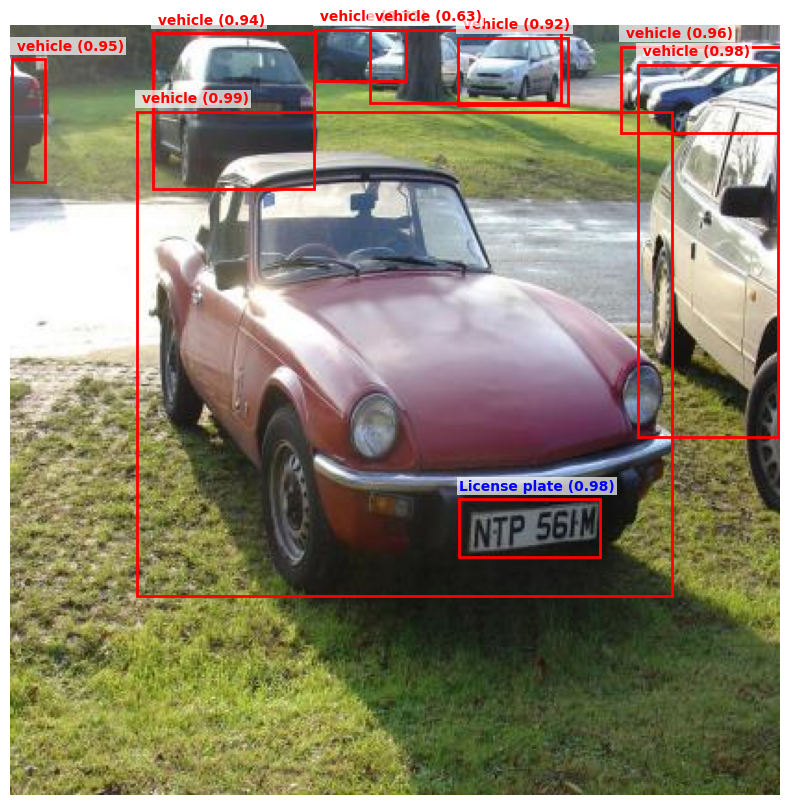

In [ ]:
# Load the unseen image
image_path = "/content/drive/MyDrive/License_Plate_data/d28d71c2690c16ed_jpg.rf.b7c4b2a5e5870d9fcf8644c109c5457f.jpg"
image_tensor = prepare_image(image_path)

with torch.no_grad():  # Disable gradient computation for inference
    prediction = model(image_tensor)

# `prediction` contains:
# - boxes: predicted bounding boxes
# - labels: predicted class labels
# - scores: predicted scores for each box (confidence level)


def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")



def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    plt.figure(figsize=fig_size)
    plt.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)

            # Set text color based on class
            if class_name == "vehicle":
                text_color = "green"
            elif class_name == "License plate":
                text_color = "blue"
            else:
                text_color = "red"  # fallback/default

            # Draw bounding box (still red)
            plt.gca().add_patch(plt.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor='red',
                facecolor='none'
            ))

            # Draw text with class-specific color
            plt.text(x_min, y_min - 5, f"{class_name} ({score:.2f})",
                     color=text_color, fontsize=10, weight='bold',
                     bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1.5))

    plt.axis('off')
    plt.show()


# Display the image with bounding boxes and correct labels
draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))  # Example of increased size
